In [1]:
from keras.layers.advanced_activations import PReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from optimizers.AdamAccumulate import AdamAccumulate
from models.u_net import UNet
from submit import generate_submit
from utilities import utils_contours
from utilities import losses

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


In [2]:
from utilities import utils_contours
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
utils_contours.set_results_reproducible()

## Predict Contours

In [4]:
input_size = 1024
train_path = "inputs/train/{}.jpg" 
train_contour_path = "inputs/train_contours/{}_contour.png"
df_train = pd.read_csv('inputs/train_masks.csv')
ids_train = df_train['img'].map(lambda s: s.split('.')[0])#[:3000]
ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=42)

print('Training on {} samples'.format(len(ids_train_split)))
print('Validating on {} samples'.format(len(ids_valid_split)))

bboxes = None
#bbox_file_path = 'inputs/train_bbox.csv'
#bboxes = utils_contours.get_bboxes(bbox_file_path)

def train_generator(batch_size):
    return utils_contours.train_generator(train_path, train_contour_path, ids_train_split, 
                                          input_size, batch_size, bboxes)

def valid_generator(batch_size):
    return utils_contours.valid_generator(train_path, train_contour_path, ids_valid_split, 
                                          input_size, batch_size, bboxes)

Training on 4070 samples
Validating on 1018 samples


In [26]:
#U-Net:
model_contour = UNet((input_size, input_size, 3), filters=8, depth=7, dropout_base_only=False, dropout=0,
             activation=lambda x: PReLU()(x), init='he_uniform')

model_contour.compile(optimizer=AdamAccumulate(accum_iters=32), 
              loss=losses.contour_weighted_bce_loss, 
              metrics=['binary_accuracy'])

In [5]:
run_name = 'unet_contour_1024-2017-09-15-2243'
model_contour.load_weights('weights/{}.hdf5'.format(run_name))
val_imgs_gt, val_contours_gt = next(valid_generator(len(ids_valid_split)))
pred_contours = model_contour.predict(val_imgs_gt, batch_size=1)

In [6]:
model_contour.evaluate(val_imgs_gt, val_contours_gt, batch_size=16)

1018/1018 [==============================] - 86s    


[0.71720933562880185, 0.99420345075472394]

In [8]:
utils_contours.save_array('outputs/unet_contour_1024-2017-09-15-2243.hdf5', pred_contours)

## Pridict Maskd

In [5]:
from utilities import utils_masks

In [6]:
train_mask_path = "inputs/train_masks/{}_mask.gif"

In [7]:
def train_mask_generator(batch_size):
    return utils_masks.train_generator(train_path, train_mask_path, ids_train_split, 
                                          input_size, batch_size, bboxes)

def valid_mask_generator(batch_size):
    return utils_masks.valid_generator(train_path, train_mask_path, ids_valid_split, 
                                          input_size, batch_size, bboxes)

In [17]:
model_seg = UNet((input_size, input_size, 3), filters=8, depth=7, dropout_base_only=False, dropout=0,
             activation=lambda x: PReLU()(x), init='he_uniform')

model_seg.compile(optimizer=AdamAccumulate(accum_iters=16), 
              loss=losses.contour_weighted_bce_loss, 
              metrics=[losses.dice_value])

model_seg.load_weights('weights/unet-2017-09-02-1809.hdf5')

In [18]:
val_imgs_gt, val_masks_gt = next(valid_mask_generator(len(ids_valid_split)))
pred_masks = model_seg.predict(val_imgs_gt, batch_size=16, verbose=1)

1018/1018 [==============================] - 92s    


In [29]:
model_seg.evaluate(val_imgs_gt, val_masks_gt, batch_size=16)

1018/1018 [==============================] - 78s    


[0.73988104253011977, 0.99637346710343722]

In [1]:
utils_contours.save_array('outputs/unet-2017-09-02-1809_pred_masks.hdf5', pred_masks)

## Add predicted contours and masks together

In [8]:
pred_masks = utils_contours.load_array('outputs/unet-2017-09-02-1809_pred_masks.hdf5')

In [9]:
pred_contours = utils_contours.load_array('outputs/unet_contour_1024-2017-09-15-2243.hdf5')

In [10]:
#val_imgs_gt, val_contours_gt = next(valid_generator(len(ids_valid_split)))
_, val_masks_gt = next(valid_mask_generator(len(ids_valid_split)))

In [11]:
print pred_contours.shape
print pred_masks.shape

(1018, 1024, 1024, 1)
(1018, 1024, 1024, 1)


In [12]:
def np_dice_value(y_true, y_pred):
    smooth = 1.
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [13]:
pred_contours_th = np.float32(pred_contours > 0.5)
#pred_masks_th = np.float32(pred_masks)
pred_masks_add = np.add(pred_masks, pred_contours_th)

In [14]:
pred_masks_add = (pred_masks_add > 0.999)
np_dice_value(val_masks_gt, pred_masks_add)

MemoryError: 

## Visualization

In [18]:
x = np.random.randint(0, len(ids_valid_split)-1, 3)
plt.figure(figsize=(25, 25))
for num, ind in enumerate(x):
    ax1 = plt.subplot(3, 3, 3*num+1)
    ax1.imshow(np.squeeze(val_masks_gt[ind]))
    ax1 = plt.subplot(3, 3, 3*num+2)
    ax1.imshow(np.squeeze(pred_masks[ind]))
    ax2 = plt.subplot(3, 3, 3*num+3)
    ax2.imshow(np.squeeze(pred_contours[ind]))
    print num, ind

NameError: name 'plt' is not defined

"plt.figure(figsize=(15, 15))\npred_masks_add = np.add(p_masks, p_contours)\np3 = plt.imshow(np.squeeze(pred_masks_add), cmap='Reds')\nplt.colorbar(p3)\n\nplt.figure(figsize=(15, 15))\np_masks_add = np.float32((pred_masks_add > 0.3))\np4 = plt.imshow(np.squeeze(p_masks_add), cmap='Reds')\nplt.colorbar(p4)\n\nplt.figure(figsize=(15, 15))\np4 = plt.imshow(np.squeeze(p_contours), cmap='Reds')\nplt.colorbar(p4)\n\nplt.figure(figsize=(15, 15))\np5 = plt.imshow(np.squeeze(p_masks), cmap='Reds')\nplt.colorbar(p5)"

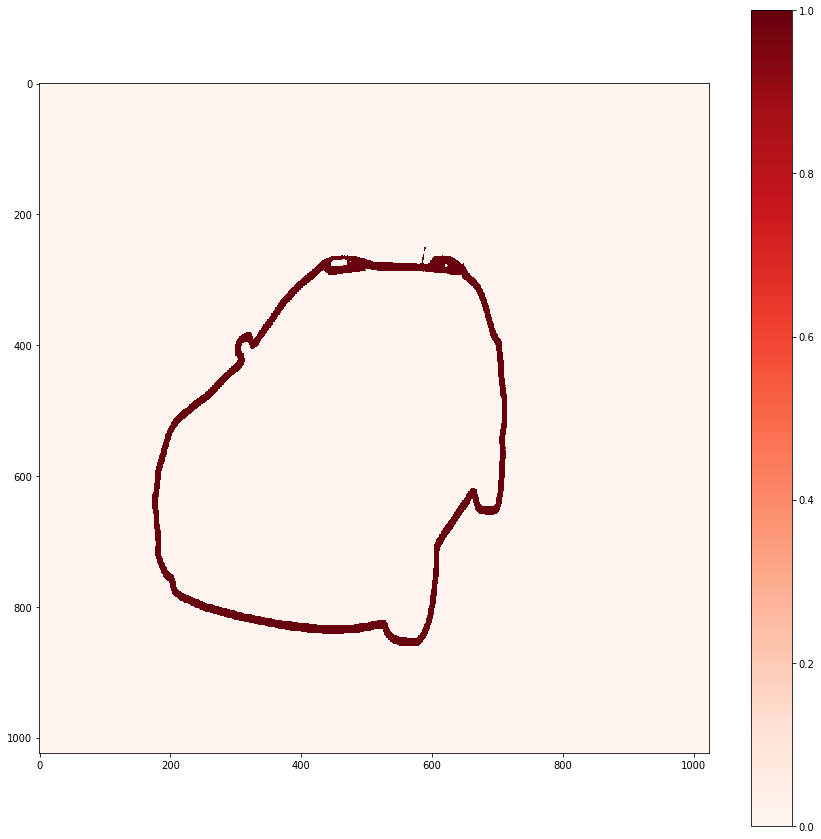

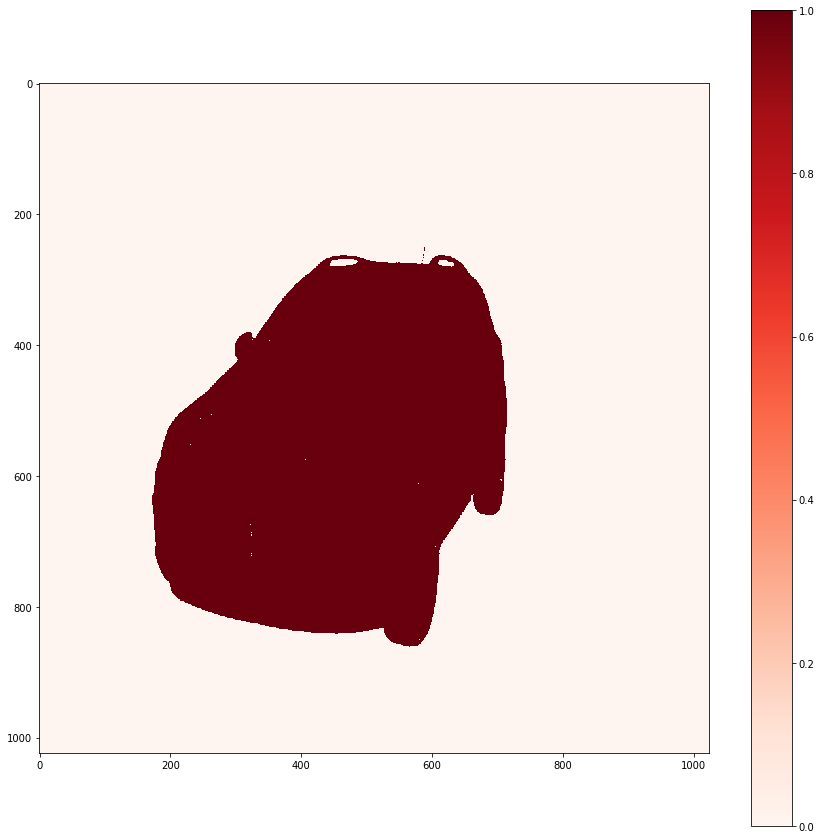

In [37]:
#pred_contours_th = pred_contours>0.5
idx = 2
p_contours = np.float32(pred_contours[idx] > 0.5 )
p_masks = np.float32(np.float32(pred_masks[idx] > 1-1e-7))
plt.figure(figsize=(15, 15))
p1 = plt.imshow(np.squeeze(p_contours), cmap='Reds')
#plt.imshow(np.squeeze(val_masks_gt[idx]), cmap='Blues', alpha=0.6)
plt.colorbar(p1)

plt.figure(figsize=(15, 15))
p2 = plt.imshow(np.squeeze(p_masks), cmap='Reds')
#p2 = plt.imshow(np.squeeze(p_masks), cmap='Blues', alpha=0.6)
plt.colorbar(p2)

'''plt.figure(figsize=(15, 15))
pred_masks_add = np.add(p_masks, p_contours)
p3 = plt.imshow(np.squeeze(pred_masks_add), cmap='Reds')
plt.colorbar(p3)

plt.figure(figsize=(15, 15))
p_masks_add = np.float32((pred_masks_add > 0.3))
p4 = plt.imshow(np.squeeze(p_masks_add), cmap='Reds')
plt.colorbar(p4)

plt.figure(figsize=(15, 15))
p4 = plt.imshow(np.squeeze(p_contours), cmap='Reds')
plt.colorbar(p4)

plt.figure(figsize=(15, 15))
p5 = plt.imshow(np.squeeze(p_masks), cmap='Reds')
plt.colorbar(p5)'''

In [ ]:
plt.